# Results: Scaling and Efficiency

In this chapter the question of how calibration time $T$ scale with the number $n$ of available processing units (PUs) will be examined. It is possible to perform two types of scaling analyses, one where the _size of the problem_ stays fixed and one where it varies with the number of PUs. As customary, I will refer to them as **weak scaling** and **strong scaling** respectively. What do I mean by _size of the problem_ in the context of derivative-free optimization? One obvious answer is the number of function evaluations, or budget, in the parlance of the Nevergrad library; but this number is a random variable when we do resampling after failing computations. Nonetheless, the budget is the infimum for the actual number of function evaluations, and it is also the number of `optimizer.tell` calls, which is the amount of information collected by the optimizer. Hence, the budget is a good definition for the size of the problem afterall, as long as one keeps in mind that he is dealing with a stochastic process. Each particular realization will not depend in a deterministic way on parameters such as the budget. However, changing the budget **will** change the distribitution and the mean value of calibration time in a deterministic way.

For evolutionary algorithms the budget is given by the number of individuals $p$ times the number of generations $g$. For these algorithms, as more thoroughly explained in previous chapters, changing the population size has drastic effects both on the result of optimization and its implementation. Indeed, the population size determines, on the one hand, the probability of escaping from a local minimum and, on the other, the degree to which optimization can be executed in parallel. The latter statement, for which we have an intuition based on the previous chapters, will be given a quantitative form later on in this one. For this reason, in the following I will consider $p$ as the size of the problem, and the number of generations $g$ fixed.

## Strong Scaling

In this analysis, the calibration notebook has been executed several times with increasing $n$ while keeping $p$ fixed. This is done using Papermill, which allows parametrizing and executing the notebooks. Later, using the Scrapbook library, it is possible to recover the objects defined during the execution (which are serialized and saved within the notebook) and the metadata saved by Papermill, such as the execution time.

The Scrapbook library offer the convenience function `read_notebooks` that takes the path of a directory and returns a scrapbook. This object has an iterator interface that yields the notebooks within that directory, and that can be used to collect the data from an ensemble of notebooks.

In [1]:
import scrapbook as sb

strong_scaling_book = sb.read_notebooks('../runs/strong_scaling')

For the sake of this analysis, we will get the data relevant to scaling using the `get_scaling_data` function from `mhpc_project.utils`. This function takes a scrapbook and for each of its notebooks checks that every code cell has been successfully executed and, if so, it stores some of its data in a Pandas dataframe.

In [2]:
from mhpc_project.utils import get_scaling_data

strong_scaling_data =  get_scaling_data(strong_scaling_book, efficiency=True)
strong_scaling_data

,num_cpus,num_generations,popsize,name,duration,efficiency
0,1024,8,512,testbed-NGO-4096-1024-6Cy,1345.692414,0.304061
1,1024,8,512,testbed-NGO-4096-1024-RJ3,1773.088293,0.232978
2,1024,8,512,testbed-NGO-4096-1024-WO3,2044.776349,0.202587
3,1024,8,512,testbed-NGO-4096-1024-hNP,1385.237619,0.298958
4,1024,8,512,testbed-NGO-4096-1024-jar,2020.561965,0.204556
5,1024,8,512,testbed-NGO-4096-1024-kDp,1536.866627,0.272461
6,1024,8,512,testbed-NGO-4096-1024-poz,1858.342462,0.223846
7,1024,8,512,testbed-NGO-4096-1024-vRr,1652.851370,0.248562
8,128,8,512,testbed-NGO-4096-128-4KN,6490.515340,0.537958
9,128,8,512,testbed-NGO-4096-128-nqq,6392.546642,0.546014


As noted above, the calibration time is a stochastic variable and, as can be seen from the entries in the previous dataframe, it can vary widely from one realization to another. However, we will be mainly concerned with its mean value $T$ (although, if needed, I will use liberally the same symbol also for the random variable and its realizations, stating explicitly what I am referring to, if not clear from the context).

The speedup $S$ is usually defined as

$$ S(n, p) = \frac{T(1, p)}{T(n, p)} \, ,$$

but since we don't have a serial execution as a reference, the following definition will be used

$$ S(n, p) = \frac{T(n_0, p)}{T(n, p)} \, ,$$

where in our case $n_0 = 32$. In case of perfect scaling $T$ is inversely proportional to $n$, and we have

$$ S(n, p) = \frac{n}{n_0} \, .$$

It is possible to improve this simple model of the computation by including the effect of the population size. If the function never fails, each PU exceeding the population size will idle. Hence, we can have perfect scaling only up to $n = p$

$$ S(n, p) = \frac{\min(n, p)}{n_0} \, .$$

This theoretical speedup should be the upper limit for the observed one.

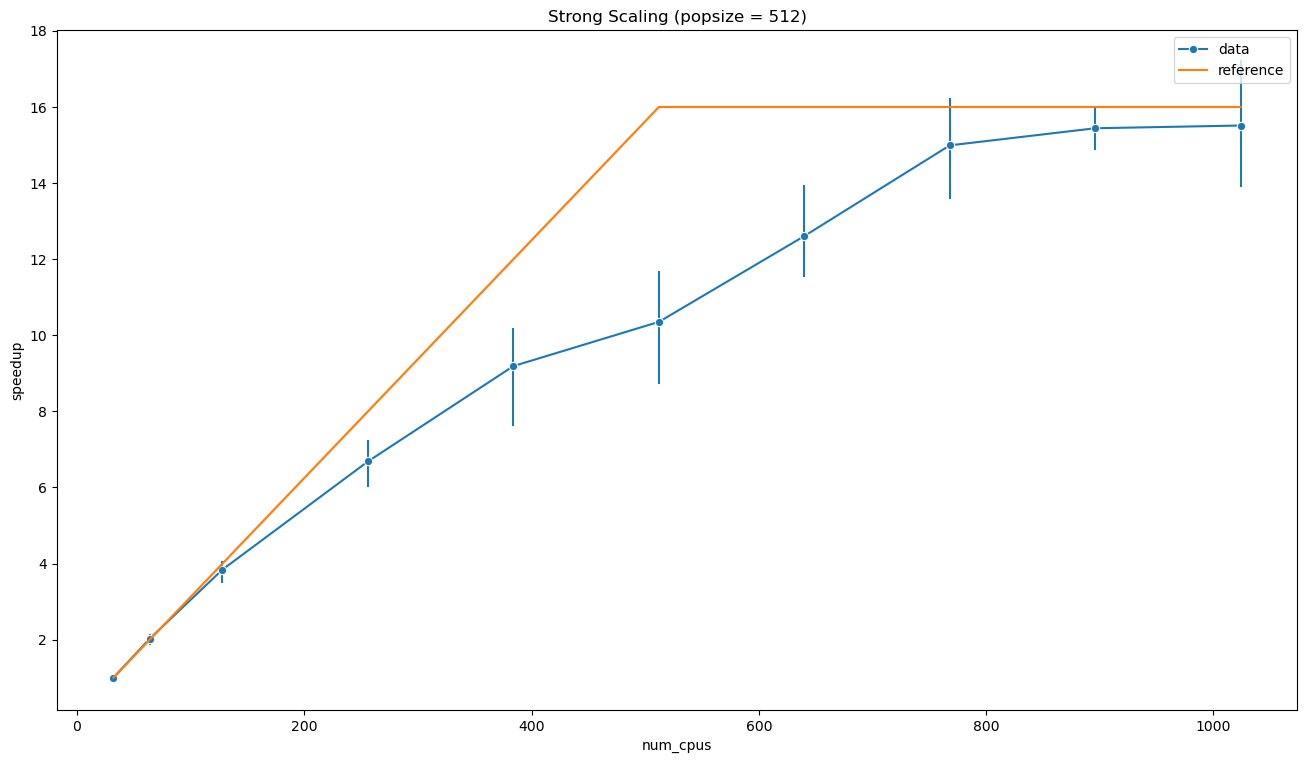

In [4]:
import mhpc_project.plots as plots
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(16,9), 'figure.dpi':100})


plots.strong_scaling(strong_scaling_data, title='Strong Scaling (popsize = 512)')
plt.show()

As can be evinced from the plot above, this simple model turns out to be very effective. Also, it is interesting to see that the execution reaches values near the theoretical maximum speedup, but with $n$ sensibly larger than $p$. One possible interpretation is that, as we know, the effective population size is larger than $p$ due to the objective failures. In principle, knowing the statistics of the objective execution times and failures, it should be possible to model more accurately the one of calibration speedup. However, I will use a simpler approach based on data. Before doing so, it is useful to take a look at the weak scaling.


## Weak Scaling

In weak scaling analysis, the calibration notebook has been executed several times with increasing $n$ and $p$, while keeping the ration $n / p$ fixed. From the strong scaling analysis we know that large $n / p$ correspond to larger errors, hence I choose $p = 2 n$ for this analysis.

In case of weak scaling, the speedup is not a meaningful metric, since the size of the problem changes. Instead, we are interested in the execution time $T$, and perfect scaling means that $T$ is constant (when the size of the problem scale proportionally to the number of PUs).

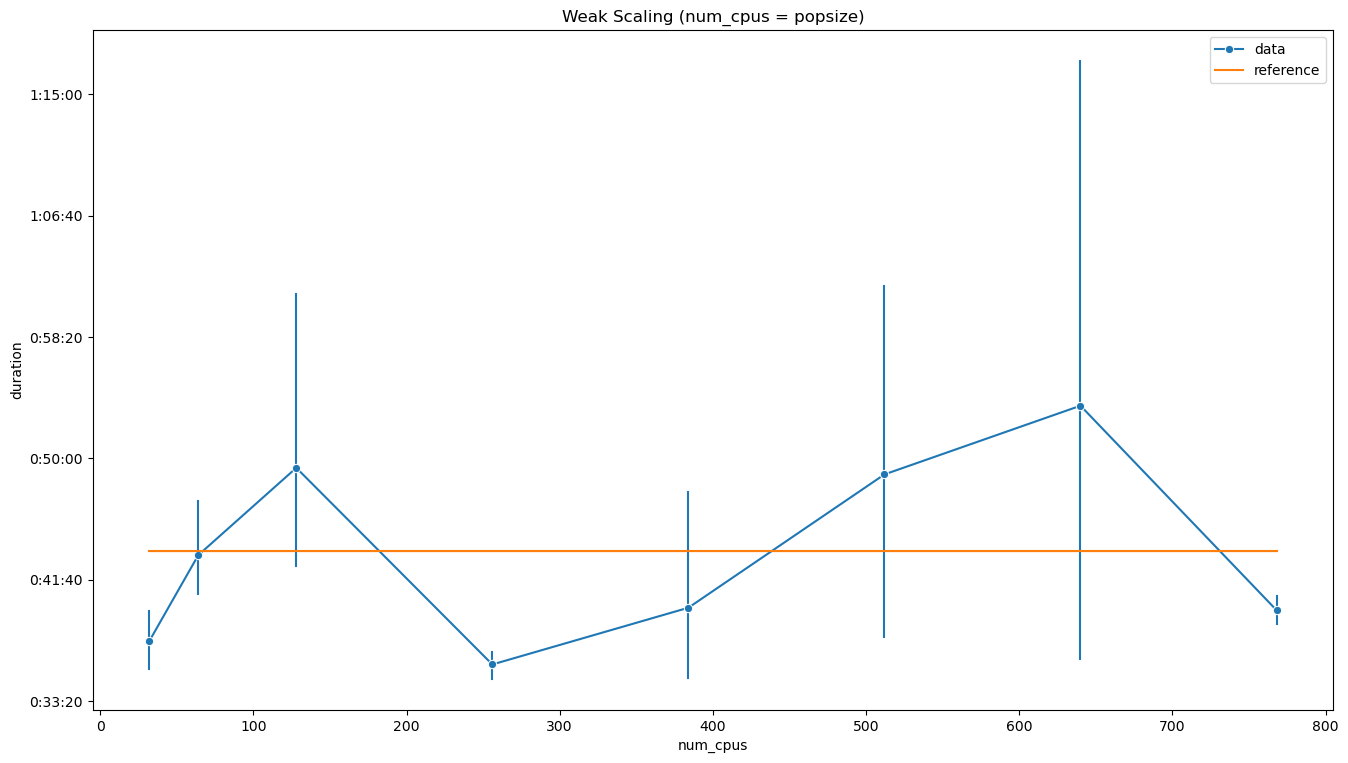

In [5]:
weak_scaling_book = sb.read_notebooks('../runs/weak_scaling')
weak_scaling_data = get_scaling_data(weak_scaling_book)
plots.weak_scaling(weak_scaling_data, title='Weak Scaling (num_cpus = popsize)')
plt.show()

The data has been loaded and plotted similarly as before. In the plot above, the reference indicating perfect scaling is chosen as the average execution time, and the hypothesis of perfect weak scaling is compatible with the data within the errors. The same thing can be shown using a linear regression plot.

In [ ]:
from mhpc_project.plots import duration_regplot
duration_regplot(weak_scaling_data)
plt.show()

This is possible since perfect weak scaling does not imply perfect strong scaling (and vice-versa). Also, the way in which we measure the _size of the problem_ affects weak scaling. However, the choice of $p$ as a measure seems reasonable, since it is plausible, at a first approximation, that the fraction of successful objective calls stays constant as we change $p$, hence the required amount of computation scales linearly with $p$.

In [ ]:
from scipy.optimize import curve_fit
from mhpc_project.utils import get_scaling_data
import seaborn as sns
import numpy as np

In [ ]:
data = get_scaling_data(strong_scaling_book, efficiency=True)
data['inverse_ratio'] =  data['popsize'] / data['num_cpus']
data['ratio'] = data['num_cpus'] / data['popsize']

In [ ]:
figure, axes = plt.subplots(figsize=(16,9), dpi=100)
sns.regplot(data=data, x='inverse_ratio', y='duration', ax=axes)

In [ ]:
(a, b), _ = curve_fit(lambda x, a, b: a / x + b, data['ratio'].to_numpy(), data['duration'].to_numpy())

In [ ]:
a, b

In [ ]:
xs = data['ratio'].to_numpy()
ys = a / xs + b
figure, axes = plt.subplots(figsize=(16,9), dpi=100)
sns.lineplot(x=xs, y=ys, ax=axes)
sns.lineplot(data=data, x='ratio', y='duration', alpha=0.7, marker='o', err_style='bars')

In [ ]:
min_cpus = data['num_cpus'].min()
duration_baseline = data[data['num_cpus'] == min_cpus]['duration'].mean()
data['speedup'] = duration_baseline / data['duration']

In [ ]:
ys = (a * 16 + b) / (a / xs + b)
figure, axes = plt.subplots(figsize=(16,9), dpi=100)
sns.lineplot(data=data, x='ratio', y='speedup', ax=axes, alpha=0.7, marker='o', err_style='bars')
sns.lineplot(x=xs, y=ys, ax=axes)

In [ ]:
r, _ = curve_fit(lambda x, r: r / (1 + x * b / a), xs, data['efficiency'].to_numpy())
r

In [ ]:
data['efficiency'].max()

In [ ]:
ys = r / (1 + xs * b / a)
figure, axes = plt.subplots(figsize=(16,9), dpi=100)
sns.lineplot(data=data, x='ratio', y='efficiency', ax=axes, alpha=0.7, marker='o', err_style='bars')
sns.lineplot(x=xs, y=ys, ax=axes)

In [ ]:
plots.strong_scaling(strong_scaling_book, title='Strong Scaling (popsize = 512)')
plt.show()

In [ ]:
plots.efficiency(strong_scaling_book, title='Efficiency in Strong Scaling (popsize = 512)')
plt.show()

In [ ]:
plots.efficiency(weak_scaling_book, title='Efficiency in Weak Scaling (num_cpus = popsize)')
plt.show()